In [16]:
# FEM numerical solution of the BVP 
# -\Delta u = 0, (x,y) \in \Omega = Cat's head
# u(left eye bdry) = 0
# u(right eye bdry = 1
# du/dn = 0 on the outer bdry

from distmesh import *
import numpy as np
import math
import matplotlib.pyplot as plt
import csv 
import scipy

count =  200 displacement =  0.013597695063160383
count =  400 displacement =  0.008952323581639289
count =  600 displacement =  0.0025008401602735837
count =  800 displacement =  0.0019422769255428437
count =  1000 displacement =  0.002497709941889449


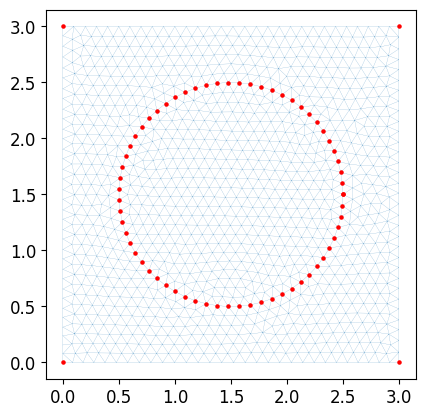

In [17]:
n_edge = 32
n_inner = 64

rad = 1.0
hole_x,hole_y = 1.5,1.5

a1 = 1
a2 = 2

_edge_var = np.linspace(0,3,n_edge)

plate = np.array([[0,0],[3,0],[3,3],[0,3]])


t = np.linspace(0,2*np.pi,n_inner)
hole = np.concatenate((np.reshape(rad*np.cos(t),(n_inner,1))+ hole_x,np.reshape(rad*np.sin(t),(n_inner,1))+ hole_y),axis = 1) 
pfix = np.concatenate((plate,hole),axis = 0)

def dfunc(p):
    dplate = dpolygon(p,plate,len(plate)) # left ear
    dhole = dpolygon(p,hole,len(hole)) # right ear
    return dplate

xmin = np.min(pfix[:,0],axis = 0)
xmax = np.max(pfix[:,0],axis = 0)
ymin = np.min(pfix[:,1],axis = 0)
ymax = np.max(pfix[:,1],axis = 0)

bbox = [xmin,xmax,ymin,ymax] # the bounding box

h0 = 0.1

pts,tri = distmesh2D(dfunc,huniform,h0,bbox,pfix)

plt.scatter(plate[:,0],plate[:,1],s = 5, c = "red")
plt.scatter(hole[:,0],hole[:,1],s = 5, c = "red")

Generating mesh...
count =  200 displacement =  0.017720437025101978
count =  400 displacement =  0.008247888269723495
count =  600 displacement =  0.004400788699142877
count =  800 displacement =  0.0030653722595184976
count =  1000 displacement =  0.005815489294210494
count =  1200 displacement =  0.0026203281603969677
count =  1400 displacement =  0.002186772994084389
count =  1600 displacement =  0.0014073784288432401
count =  1800 displacement =  0.00282703017654192
count =  2000 displacement =  0.003487629533225801
count =  2200 displacement =  0.009850246929411197
count =  2400 displacement =  0.0034296924821056963
count =  2600 displacement =  0.0014145412581084405
Mesh generated with 4324 points and 8388 triangles.

--- Running Simulation for a1 = 1.2, a2 = 1.0 ---
Assembling stiffness matrix...
Applying boundary conditions...
Solving linear system...
Calculating gradient and current density...
Averaging current density to vertices...
Plotting results...


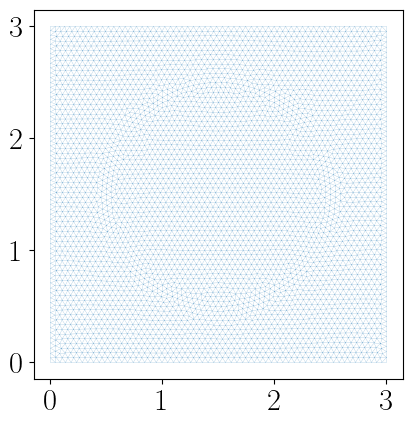

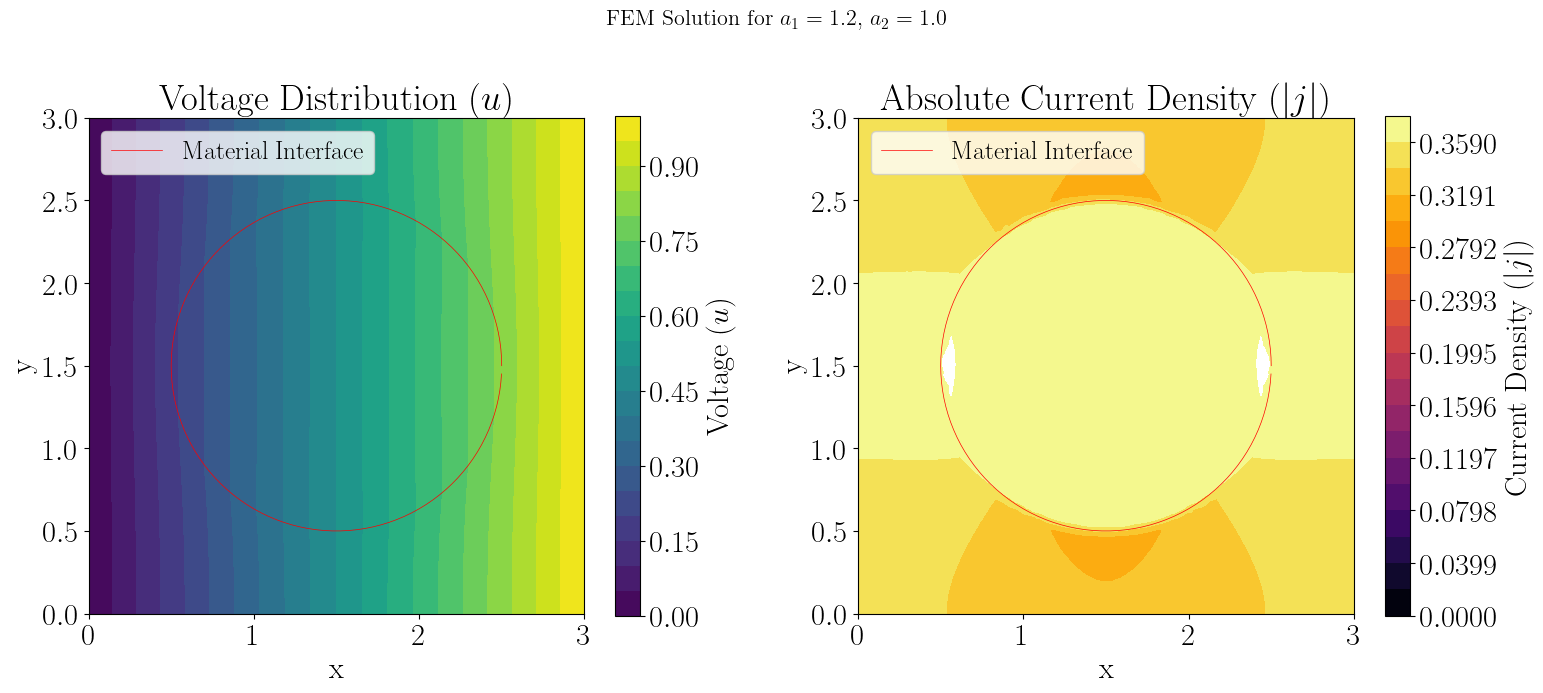


--- Running Simulation for a1 = 0.8, a2 = 1.0 ---
Assembling stiffness matrix...
Applying boundary conditions...
Solving linear system...
Calculating gradient and current density...
Averaging current density to vertices...
Plotting results...


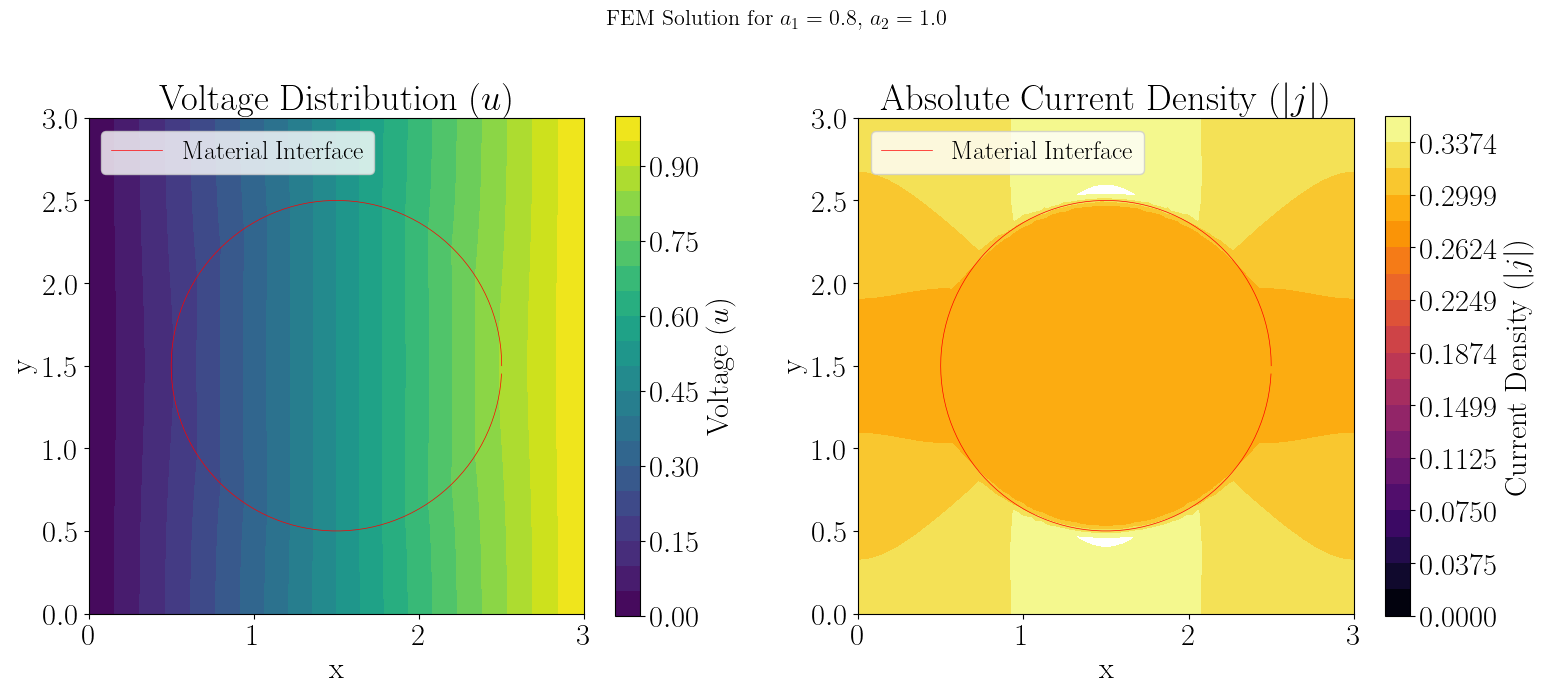

In [25]:
# %% Import necessary libraries
import numpy as np
import scipy.sparse as sps
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
from distmesh import distmesh2D, drectangle, dcircle, ddiff, dunion, huniform
import math
plt.rcParams.update({
    "text.usetex": True,  # Use LaTeX for text rendering
    "font.family": "serif",  # Set the font family to serif
    "font.serif": ["Times New Roman"],  # Specify the serif font
    "font.size": 22,  # Set the default font size
})

# %% Define geometry and mesh parameters

# Domain boundaries
xmin, xmax = 0.0, 3.0
ymin, ymax = 0.0, 3.0
bbox = [xmin, xmax, ymin, ymax]

# Internal circle parameters
center_x, center_y = 1.5, 1.5
radius = 1.0

# Desired mesh size
h0 = 0.05 # Adjust for finer/coarser mesh

# --- Define Fixed Points ---
# 1. Corners of the square
pfix_corners = np.array([
    [xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]
])

# 2. Points on the internal circle boundary
# 2. Points on the internal circle boundary
num_circle_pts = int(np.ceil(2 * np.pi * radius / h0)) # Number of points based on h0
# Generate angles evenly spaced around the circle (0 to 2*pi, excluding endpoint to avoid duplication)
theta = np.linspace(0, 2 * np.pi, num_circle_pts, endpoint=False)
# Calculate x and y coordinates using standard circle equations
circle_x = center_x + radius * np.cos(theta)
circle_y = center_y + radius * np.sin(theta)
# Stack them into a (num_circle_pts, 2) array
pfix_circle = np.column_stack((circle_x, circle_y))

# Combine fixed points (corners and circle points)
pfix = np.vstack([pfix_corners, pfix_circle])

# --- Signed Distance Function (simple rectangle for domain boundary) ---
# We rely on pfix to capture the internal boundary
def dfunc(p):
    return drectangle(p, xmin, xmax, ymin, ymax)

# --- Generate Mesh ---
print("Generating mesh...")
pts, tri = distmesh2D(dfunc, huniform, h0, bbox, pfix)
print(f"Mesh generated with {pts.shape[0]} points and {tri.shape[0]} triangles.")

Npts = pts.shape[0] # Number of mesh points (nodes)
Ntri = tri.shape[0] # Number of mesh triangles (elements)

# %% Define Finite Element Functions

# Stiffness matrix for one triangle (Laplacian term, constant coefficient)
def stima3(verts):
    """Computes the 3x3 element stiffness matrix for a triangle."""
    # Check orientation (ensure positive area) - swap if needed for consistent orientation
    # This helps ensure the determinant is positive in the formula
    if np.linalg.det(np.hstack([np.ones((3, 1)), verts])) < 0:
        verts = verts[[0, 2, 1], :] # Swap vertices 1 and 2

    Aux = np.ones((3, 3))
    Aux[0:2, :] = verts.T # Use transpose to match formula style common elsewhere
    rhs = np.zeros((3, 2))
    rhs[0, 0] = 1 # Corrected index based on typical FEM basis function derivatives
    rhs[1, 1] = 1 # Corrected index based on typical FEM basis function derivatives

    # Solve for gradients of basis functions
    # This implicitly finds coeffs c1,c2,c3 such that N_i(x,y) = c1 + c2*x + c3*y
    # The gradients are then [c2, c3]
    try:
        # G = np.linalg.solve(Aux.T, rhs) # Gradients are rows
        # Correction: Need to match stima3 logic (often based on inverse)
        C = np.linalg.inv(np.hstack([np.ones((3, 1)), verts]))
        G = C[1:3,:] # Gradients of basis functions N1, N2, N3 are columns 1,2 of C
    except np.linalg.LinAlgError:
        print("Singular matrix in stima3, likely degenerate triangle.")
        print("Vertices:", verts)
        return np.zeros((3, 3)) # Return zero matrix for degenerate triangles


    # Calculate area using determinant
    Area = 0.5 * abs(np.linalg.det(np.hstack([np.ones((3, 1)), verts])))
    if Area < 1e-14:
         print("Warning: Triangle with near-zero area encountered:", Area)
         return np.zeros((3,3))

    # Element stiffness matrix M_ij = Area * (grad(N_i) . grad(N_j))
    M = Area * (G.T @ G) # Correct dot product of gradients
    return M


# %% Assign conductivity values to triangles
a_tri = np.zeros(Ntri)
centroids = np.zeros((Ntri, 2))

# Function to run simulation for given conductivities
def run_simulation(a1, a2):
    """Runs the FEM simulation and plotting for given a1 and a2."""
    print(f"\n--- Running Simulation for a1 = {a1}, a2 = {a2} ---")

    # 1. Assign conductivity to each triangle based on its centroid
    for j in range(Ntri):
        verts = pts[tri[j, :], :]
        centroids[j, :] = np.mean(verts, axis=0)
        cx, cy = centroids[j, :]
        # Check if centroid is inside the circle (region 1)
        if (cx - center_x)**2 + (cy - center_y)**2 < radius**2:
            a_tri[j] = a1
        else:
            a_tri[j] = a2

    # %% Assemble Stiffness Matrix A and RHS b (initially zero)
    A = sps.lil_matrix((Npts, Npts), dtype=float) # Use LIL format for efficient assembly
    b = np.zeros((Npts, 1))
    u = np.zeros((Npts, 1)) # Solution vector

    print("Assembling stiffness matrix...")
    for j in range(Ntri):
        verts = pts[tri[j, :], :] # Vertices of triangle j
        indices = tri[j, :]      # Global indices of the vertices
        M_laplace = stima3(verts) # Element stiffness for Laplacian
        a_T = a_tri[j]            # Conductivity for this triangle
        M_element = a_T * M_laplace # Scale by conductivity

        # Add element matrix to global matrix A using global indices
        for row in range(3):
            for col in range(3):
                A[indices[row], indices[col]] += M_element[row, col]

    A = A.tocsr() # Convert to CSR for faster matrix operations

    # %% Apply Boundary Conditions
    print("Applying boundary conditions...")
    tol = 1e-6 # Tolerance for finding boundary nodes

    # Find nodes on Dirichlet boundaries
    dirichlet_nodes_0 = np.where(abs(pts[:, 0] - xmin) < tol)[0] # u = 0 on left edge (x=xmin)
    dirichlet_nodes_1 = np.where(abs(pts[:, 0] - xmax) < tol)[0] # u = 1 on right edge (x=xmax)
    dirichlet_nodes = np.unique(np.concatenate((dirichlet_nodes_0, dirichlet_nodes_1)))

    # Set known values in the solution vector u
    u[dirichlet_nodes_0] = 0.0
    u[dirichlet_nodes_1] = 1.0

    # Identify free nodes (nodes where u is unknown)
    all_nodes = np.arange(Npts)
    free_nodes = np.setdiff1d(all_nodes, dirichlet_nodes, assume_unique=True)

    # Modify the system Ax=b for the known Dirichlet values
    # Calculate b = -A_known * u_known (adjust RHS for known values)
    # More robust approach: modify A and b directly (or solve reduced system)

    # Create the reduced system for free nodes
    # Calculate RHS contribution from fixed nodes: b_free = -A[free_nodes, :][:, dirichlet_nodes] @ u[dirichlet_nodes]
    b_mod = -A[:, dirichlet_nodes] @ u[dirichlet_nodes] # Calculate contributions to all nodes first
    b_free = b_mod[free_nodes] # Extract RHS for free nodes


    # Extract the submatrix corresponding to free nodes
    A_free = A[free_nodes, :][:, free_nodes]

    # %% Solve the Linear System
    print("Solving linear system...")
    u_free = spla.spsolve(A_free, b_free)
    u[free_nodes, 0] = u_free # Fill in the computed values in the solution vector
    u_flat = u.flatten() # Flatten for plotting

    # %% Calculate Gradient and Current Density
    print("Calculating gradient and current density...")
    grad_u_centers = np.zeros((Ntri, 2)) # Store gradient (du/dx, du/dy) at triangle centers
    abs_current_centers = np.zeros(Ntri)  # Store |j| = |-a * grad(u)| at triangle centers

    for j in range(Ntri):
        indices = tri[j, :]
        verts = pts[indices, :]
        u_local = u[indices, 0] # Voltage values at the vertices of triangle j

        # Calculate triangle area (ensure positive)
        x1, y1 = verts[0, :]
        x2, y2 = verts[1, :]
        x3, y3 = verts[2, :]
        Area = 0.5 * abs(x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))

        if Area < 1e-14:
            grad_u_centers[j, :] = 0.0 # Avoid division by zero for degenerate triangles
        else:
            # Calculate gradient components using the formula derived in the prompt
            # Note the cyclic permutation and division by 2*Area
            # du/dx = (u1*(y2-y3) + u2*(y3-y1) + u3*(y1-y2)) / (2*Area)
            # du/dy = (u1*(x3-x2) + u2*(x1-x3) + u3*(x2-x1)) / (2*Area)
            dudx = (u_local[0] * (y2 - y3) + u_local[1] * (y3 - y1) + u_local[2] * (y1 - y2)) / (2 * Area)
            dudy = (u_local[0] * (x3 - x2) + u_local[1] * (x1 - x3) + u_local[2] * (x2 - x1)) / (2 * Area)
            grad_u_centers[j, 0] = dudx
            grad_u_centers[j, 1] = dudy

        # Calculate current density j = -a * grad(u)
        a_T = a_tri[j]
        jx = -a_T * grad_u_centers[j, 0]
        jy = -a_T * grad_u_centers[j, 1]

        # Calculate absolute value of current density
        abs_current_centers[j] = np.sqrt(jx**2 + jy**2)

    # %% Average Current Density Magnitude to Vertices for Plotting
    print("Averaging current density to vertices...")
    abs_current_verts = np.zeros(Npts)
    count_tri = np.zeros(Npts, dtype=int) # Use int for counts

    for j in range(Ntri):
        indices = tri[j, :]
        abs_current_verts[indices] += abs_current_centers[j]
        count_tri[indices] += 1

    # Avoid division by zero for nodes not part of any triangle (shouldn't happen with distmesh)
    # or nodes only connected to degenerate triangles
    valid_counts = count_tri > 0
    abs_current_verts[valid_counts] = abs_current_verts[valid_counts] / count_tri[valid_counts]
    # Handle potential division by zero if a node isn't in count_tri (unlikely)
    abs_current_verts[~valid_counts] = 0 # Assign 0 if count is 0


    # %% Visualization
    print("Plotting results...")
    fig, axs = plt.subplots(1, 2, figsize=(16, 7))
    fig.suptitle(f'FEM Solution for $a_1={a1}$, $a_2={a2}$', fontsize=16)

    # Plot Voltage (u)
    ax = axs[0]
    contour = ax.tricontourf(pts[:, 0], pts[:, 1], tri, u_flat, cmap='viridis', levels=20)
    fig.colorbar(contour, ax=ax, label='Voltage ($u$)')
    ax.plot(pfix_circle[:, 0], pfix_circle[:, 1], 'r-', lw=0.5, label='Material Interface') # Show interface
    ax.set_title('Voltage Distribution ($u$)')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_aspect('equal', adjustable='box')
    ax.legend(loc='upper left', fontsize='small')


    # Plot Absolute Current Density (|j|)
    ax = axs[1]
    max_current = np.percentile(abs_current_verts, 99.5) # Avoid extreme values skewing colorbar
    contour = ax.tricontourf(pts[:, 0], pts[:, 1], tri, abs_current_verts, cmap='inferno', levels=np.linspace(0,max_current, 20)) # Use averaged values
    fig.colorbar(contour, ax=ax, label='Current Density ($|j|$)')
    ax.plot(pfix_circle[:, 0], pfix_circle[:, 1], 'r-', lw=0.5, label='Material Interface') # Show interface
    ax.set_title('Absolute Current Density ($|j|$)')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_aspect('equal', adjustable='box')
    ax.legend(loc='upper left', fontsize='small')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

    return u_flat, abs_current_verts # Return results if needed

# %% Run the two cases

# Case (a): a1 > a2 (inner circle more conductive)
a1_case_a = 1.2
a2_case_a = 1.0
u_a, j_a = run_simulation(a1_case_a, a2_case_a)

# Case (b): a1 < a2 (inner circle less conductive)
a1_case_b = 0.8
a2_case_b = 1.0
u_b, j_b = run_simulation(a1_case_b, a2_case_b)

Generating mesh...
count =  200 displacement =  0.013597695063137762
count =  400 displacement =  0.008952323270983732
count =  600 displacement =  0.0025008401558097564
count =  800 displacement =  0.0019422769255981406
count =  1000 displacement =  0.0024977099442375613
Mesh generated with 1116 points and 2104 triangles.


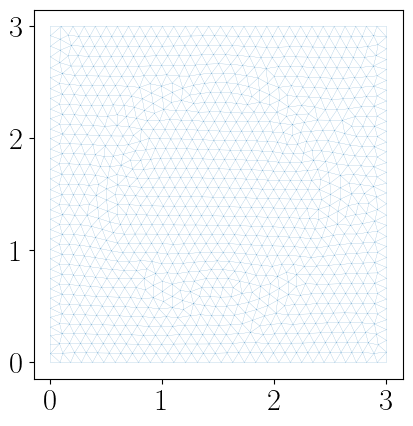

In [19]:
import numpy as np
import scipy.sparse as sps
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
from distmesh import distmesh2D, drectangle, huniform
import math

xmin, xmax = 0.0, 3.0
ymin, ymax = 0.0, 3.0
bbox = [xmin, xmax, ymin, ymax]

center_x, center_y = 1.5, 1.5
radius = 1.0
h0 = 0.1

pfix_corners = np.array([
    [xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]
])

num_circle_pts = int(np.ceil(2 * np.pi * radius / h0))
theta = np.linspace(0, 2 * np.pi, num_circle_pts, endpoint=False)
circle_x = center_x + radius * np.cos(theta)
circle_y = center_y + radius * np.sin(theta)
pfix_circle = np.column_stack((circle_x, circle_y))
pfix = np.vstack([pfix_corners, pfix_circle])

def dfunc(p):
    return drectangle(p, xmin, xmax, ymin, ymax)

print("Generating mesh...")
pts, tri = distmesh2D(dfunc, huniform, h0, bbox, pfix)
print(f"Mesh generated with {pts.shape[0]} points and {tri.shape[0]} triangles.")

Npts = pts.shape[0]
Ntri = tri.shape[0]

def stima3(verts):
    if np.linalg.det(np.hstack([np.ones((3, 1)), verts])) < 0:
        verts = verts[[0, 2, 1], :]
    Aux = np.ones((3, 3))
    Aux[0:2, :] = verts.T
    rhs = np.zeros((3, 2))
    rhs[0, 0] = 1
    rhs[1, 1] = 1
    try:
        C = np.linalg.inv(np.hstack([np.ones((3, 1)), verts]))
        G = C[1:3, :]
    except np.linalg.LinAlgError:
        return np.zeros((3, 3))
    Area = 0.5 * abs(np.linalg.det(np.hstack([np.ones((3, 1)), verts])))
    if Area < 1e-14:
        return np.zeros((3, 3))
    M = Area * (G.T @ G)
    return M

a_tri = np.zeros(Ntri)
centroids = np.zeros((Ntri, 2))

def run_simulation(a1, a2):
    print(f"\n--- Running Simulation for a1 = {a1}, a2 = {a2} ---")
    for j in range(Ntri):
        verts = pts[tri[j, :], :]
        centroids[j, :] = np.mean(verts, axis=0)
        cx, cy = centroids[j, :]
        if (cx - center_x)**2 + (cy - center_y)**2 < radius**2:
            a_tri[j] = a1
        else:
            a_tri[j] = a2

    A = sps.lil_matrix((Npts, Npts), dtype=float)
    b = np.zeros((Npts, 1))
    u = np.zeros((Npts, 1))

    print("Assembling stiffness matrix...")
    for j in range(Ntri):
        verts = pts[tri[j, :], :]
        indices = tri[j, :]
        M_laplace = stima3(verts)
        a_T = a_tri[j]
        M_element = a_T * M_laplace
        for row in range(3):
            for col in range(3):
                A[indices[row], indices[col]] += M_element[row, col]

    A = A.tocsr()
    print("Applying boundary conditions...")
    tol = 1e-6
    dirichlet_nodes_0 = np.where(abs(pts[:, 0] - xmin) < tol)[0]
    dirichlet_nodes_1 = np.where(abs(pts[:, 0] - xmax) < tol)[0]
    dirichlet_nodes = np.unique(np.concatenate((dirichlet_nodes_0, dirichlet_nodes_1)))
    u[dirichlet_nodes_0] = 0.0
    u[dirichlet_nodes_1] = 1.0
    all_nodes = np.arange(Npts)
    free_nodes = np.setdiff1d(all_nodes, dirichlet_nodes, assume_unique=True)
    b_mod = -A[:, dirichlet_nodes] @ u[dirichlet_nodes]
    b_free = b_mod[free_nodes]
